In [3]:
import MDAnalysis as mda
from MDAnalysis.auxiliary import EDR
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.align as align
import MDAnalysis.analysis.hydrogenbonds
import MDAnalysis.analysis.diffusionmap as diffusionmap

import numpy as np

# Import viewer
import nglview
import ipywidgets

# Import matplotlib - for plotting data
import matplotlib.pyplot as plt
# Import statistics Library
import statistics

#other general things
import warnings
import os


## Inputs

### Inputs files and options

In [12]:
### Needed input
sim_path = 'D:\hAHR-ITE\GROMACS-hAHR\WTApo\\' 
coordinate_file_name = 'md1ns.gro'             ##tpr or gro file tpr needed for h bond
trajectory_file_name = 'md1ns.xtc'      ##xtc file
auxiliary_file_name = 'md1ns.edr'              ##edr file
reference_structure_path = 'npt.gro'
ligand_name = "ITE" #set to None if no ligand
sim_name = 'default' ##output pdb file will use thise name, if set to "default" will use the auxilliary file name

#Options
align_traj = False #will generate, and reload a protein aligned trajectory (run once then it will be auto used as input)
radius_of_gyration = True

calculate_RMSD = True
RMSD_groups = ["284 to 400" , "400 to 426" ]
RMSD_groups_name = ["Core" , "C-term" ]

calculate_RMSF = False

pairwise_RMSD = False

H_bonds = False
start_frame = 100
stop_frame = None

edr_only = True



if sim_name == 'default':
    sim_name = auxiliary_file_name.split(".")[0]

RMSD_groups_name.insert(0, "Overall")

### Reading and preprocessing

In [13]:

## Read the diferent files
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not edr_only:
        reference_structure = mda.Universe(sim_path + reference_structure_path,)
        if os.path.isfile(sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc") and not  align_traj: ## read the aligned file if it exist
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
            print("Aligned file found, reading this instead")
            is_aligned = True
        else:
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
            is_aligned = False
    energy_like_terms = EDR.EDRReader(sim_path + auxiliary_file_name)


In [14]:
def do_trajectory_CAalignement():
    average = align.AverageStructure(atomistic_system, atomistic_system, select='protein and name CA', ref_frame=0)
    print("Calculating averaged structure:")
    average.run(verbose=True)
    averaged_ref = average.results.universe
    # Align all structure on the averaged one
    aligner = align.AlignTraj(atomistic_system, 
                                  averaged_ref, 
                                  select='protein and name CA',
                                  in_memory=False,
                                  filename=sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    
    print("align trajectory on the averaged one, save as " + sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    aligner.run(verbose=True)

if align_traj:
    atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
    do_trajectory_CAalignement()
    atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    is_aligned = True


    

## Sanity Check
Check that simulation isn't going wrong, read temperature and pressure through the EDR <br>
list of the available data can be obtained with: <br>


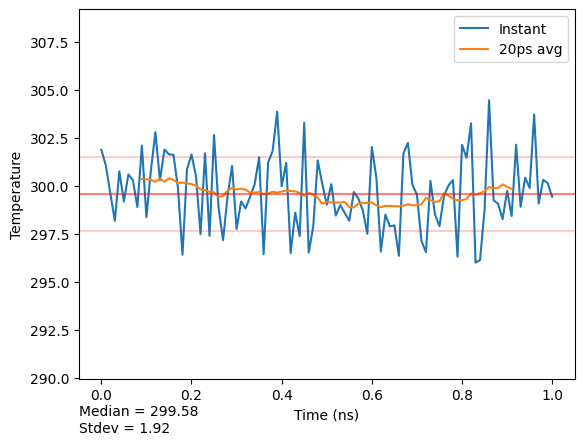

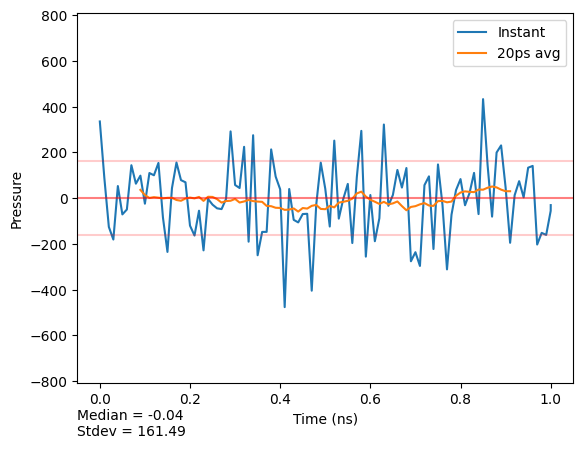

In [19]:
## Def some plotting functions
def plt_median(ax,array, n=1, positive=True, negative=True, label=False):
    # plt median and +- stdev
    median = statistics.median(array)
    stdev = statistics.stdev(array[2:]) #skip 2 1st frame
    
    if label:
        ax.text(x=0, y=-0.07, ha="left", va="top", s=f"Median = {median:.2f}\nStdev = {stdev:.2f}", transform = ax.transAxes)

    ax.axhline(y = median, color = 'r', linestyle = '-', alpha = 0.5)
    if positive:
        ax.axhline(y = median + n*stdev, color = 'r', linestyle = '-', alpha=0.2)
    if negative:
        ax.axhline(y = median - n*stdev, color = 'r', linestyle = '-', alpha =0.2)
    
    return median, stdev

def plt_smooth(ax,data_array,time_array,window):
    ## Use convolution to smooth an array on a sliding window anď plot it on the ax plot
    avg = np.convolve(data_array, np.ones(window)/window, mode='valid')
    slice_start = int(window/2-1)
    slice_finish = int(window/2)
    ax.plot(time_array[slice_start:-slice_finish]/1000, avg, label= str(window) + "ps avg")

def edr_plot(data_label):
    #get data
    edr_data = energy_like_terms.get_data(data_label)

    #plot data
    fig, ax1 = plt.subplots()
    ax1.plot(edr_data['Time']/1000, edr_data[data_label], label = "Instant")

    # Plt axis
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel(data_label)

    plt_smooth(ax1,edr_data[data_label],edr_data['Time'],20)
    median, stdev = plt_median(ax1,edr_data[data_label], label = True)

    # Set axis limits
    ax1.set_ylim(median - 5 * stdev, median + 5 * stdev)
    if not edr_only:
        ax1.set_xlim(0, len(edr_data['Time'])/100)

    plt.legend()
    plt.show()

edr_plot('Temperature')
edr_plot('Pressure')
edr_plot('Potential')



### Temperature

In [8]:
#get data
temperature_data = energy_like_terms.get_data('Temperature')

#plot data
fig, ax1 = plt.subplots()
ax1.plot(temperature_data['Time']/1000, temperature_data['Temperature'], label = "Instant")

# Plt axis
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Temperature (K)')

plt_smooth(ax1,temperature_data['Temperature'],temperature_data['Time'],20)
plt_median(ax1,temperature_data['Temperature'], label = True)

# Set axis limits
ax1.set_ylim(290,310)
if not edr_only:
    ax1.set_xlim(0, len(temperature_data['Time'])/100)

plt.legend()
plt.show()

KeyError: "data selector Temperature is invalid. Check the EDRReader's `terms` attribute."

### Pressure

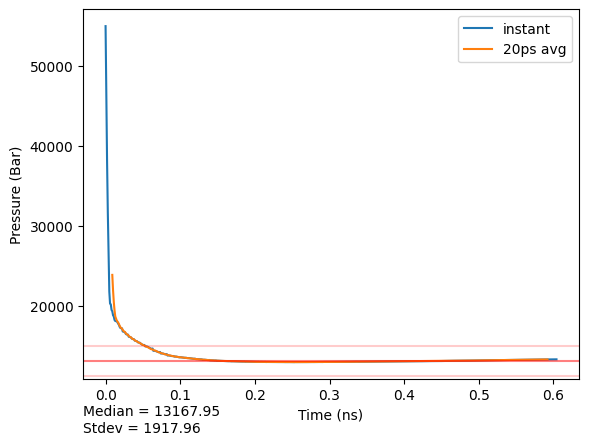

In [ ]:
#Get and plot Density data
pressure_data = energy_like_terms.get_data('Pressure')

#plot data
fig, ax1 = plt.subplots()
ax1.plot(pressure_data['Time']/1000, pressure_data['Pressure'], label="instant")


plt_smooth(ax1,pressure_data['Pressure'],pressure_data['Time'],20)
plt_median(ax1,pressure_data['Pressure'], label=True)

# Plt axis
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Pressure (Bar)')


# Set axis limits
#plt.ylim(280,320)
if not edr_only:
    ax1.set_xlim(0, len(pressure_data['Time'])/100)

plt.legend()
plt.show()

### Density

In [ ]:
#Get and plot Density data
density_data = energy_like_terms.get_data('Density')

fig, ax1 = plt.subplots()
ax1.plot(density_data['Time']/1000, density_data['Density'], label="instant")

#smoothed and median + stddev view
plt_smooth(ax1,density_data['Density'],density_data['Time'],20)
plt_median(ax1,density_data['Density'])

# Plt axis
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Density')

# Set axis limits
#plt.ylim(280,320)
if not edr_only:
    ax1.set_xlim(0, len(density_data['Time'])/100)

plt.legend()
plt.show()

KeyError: "data selector Density is invalid. Check the EDRReader's `terms` attribute."

### Energy

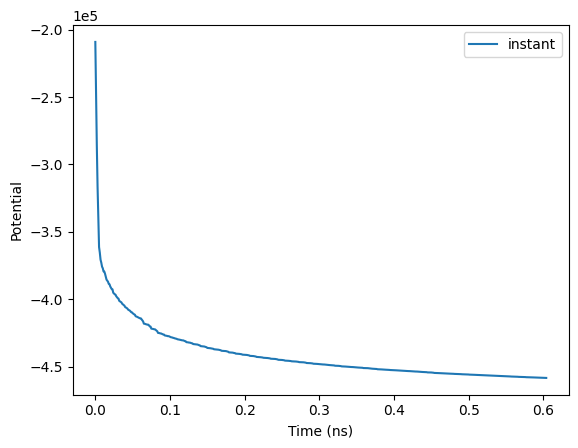

In [ ]:
#Get and plot Density data
energy_data = energy_like_terms.get_data('Potential')



fig, ax1 = plt.subplots()
ax1.plot(energy_data['Time']/1000, energy_data['Potential'], label="instant")


# Plt axis
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Potential')

#smoothed and median + stddev view
#plt_smooth(ax1,energy_data['Potential'],energy_data['Time'],20)
#plt_median(ax1,energy_data['Potential'])

# Set axis limits
#plt.ylim(280,320)
#ax1.set_xlim(0, len(energy_data['Time'])/100)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend()
plt.show()

{'Time': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  15.,  17.,  18.,  19.,  20.,  22.,  23.,  24.,
        26.,  27.,  28.,  30.,  31.,  32.,  34.,  35.,  36.,  38.,  39.,
        40.,  42.,  43.,  44.,  46.,  47.,  48.,  49.,  50.,  52.,  53.,
        54.,  56.,  57.,  58.,  59.,  60.,  61.,  63.,  64.,  65.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  77.,  78.,  79.,  80.,
        82.,  83.,  84.,  86.,  87.,  88.,  89.,  91.,  92.,  93.,  95.,
        96.,  97.,  98.,  99., 101., 103., 104., 105., 106., 108., 109.,
       110., 112., 113., 114., 115., 116., 117., 118., 120., 121., 122.,
       124., 125., 126., 127., 129., 130., 131., 133., 134., 135., 136.,
       137., 139., 140., 141., 143., 144., 145., 146., 148., 149., 150.,
       152., 153., 154., 155., 157., 158., 159., 161., 162., 163., 164.,
       165., 167., 168., 169., 171., 172., 173., 174., 175., 177., 178.,
       179., 181., 182., 183., 184., 186.,

KeyError: 'Total Energy'

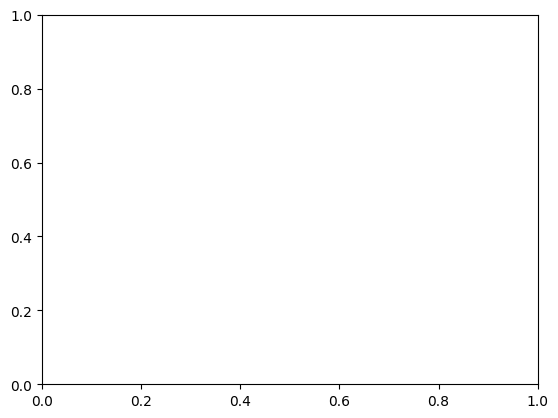

In [ ]:
#Get and plot Density data
energy_data = energy_like_terms.get_data('Total Energy')



fig, ax1 = plt.subplots()
ax1.plot(energy_data['Time']/1000, energy_data['Total Energy'], label="instant")


# Plt axis
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Total Energy')

#smoothed and median + stddev view
plt_smooth(ax1,energy_data['Total Energy'],energy_data['Time'],20)
plt_median(ax1,energy_data['Total Energy'])

# Set axis limits
#plt.ylim(280,320)
ax1.set_xlim(0, len(energy_data['Time'])/100)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend()
plt.show()

### Box size

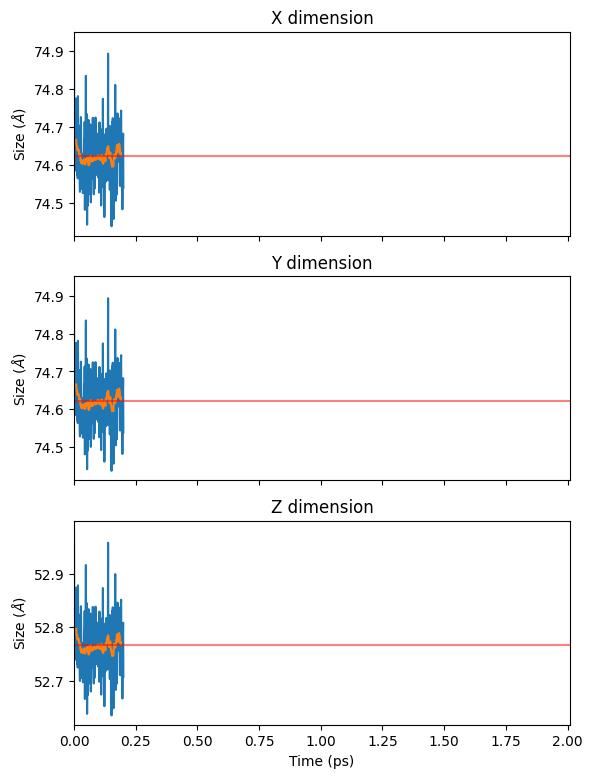

In [ ]:
#Get and plot Density data
box_X_data = energy_like_terms.get_data('Box-X')
box_Y_data = energy_like_terms.get_data('Box-Y')
box_Z_data = energy_like_terms.get_data('Box-Z')

fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(box_X_data['Time']/1000, box_X_data['Box-X'])
plt_smooth(axs[0],box_X_data['Box-X'],box_X_data['Time'],20)
plt_median(axs[0],box_X_data['Box-X'], positive=False, negative=False)
axs[0].set_title("X dimension")

axs[1].plot(box_Y_data['Time']/1000, box_Y_data['Box-Y'])
plt_smooth(axs[1],box_Y_data['Box-Y'],box_Y_data['Time'],20)
plt_median(axs[1],box_Y_data['Box-Y'], positive=False, negative=False)
axs[1].set_title("Y dimension")

axs[2].plot(box_Z_data['Time']/1000, box_Z_data['Box-Z'])
plt_smooth(axs[2],box_Z_data['Box-Z'],box_X_data['Time'],20)
plt_median(axs[2],box_Z_data['Box-Z'], positive=False, negative=False)
axs[2].set_title("Z dimension")
axs[2].set(xlabel='Time (ps)')

for ax in axs:
    ax.set(ylabel='Size ($\AA$)', xlim=(0, len(energy_data['Time'])/100))
    


fig.set(figheight=9)

# Set axis limits
plt.xlim(0, len(energy_data['Time'])/100)
plt.show()

## View the simulation

In [ ]:
# Open an NGLView widget
view = nglview.show_mdanalysis(atomistic_system, default_representation=False)

# Add the atomistic system to the widget
view.add_representation('cartoon', selection='protein')


# Draw a licorice representation of the ligand
#view.add_representation('licorice', selection='water')

# Add spacefill representtaion for the ions (Potassium, Chloride)
view.add_representation('spacefill', selection='.POT .CLA', opacity=0.5)

# Center the view
if ligand_name:
    view.center(ligand_name)
    view.add_representation('licorice', selection= ligand_name )
else:
    view.center('protein')

# Set the view to orthographic
view.camera = 'orthographic'

# Show the view in the widget
view

NameError: name 'atomistic_system' is not defined

## Analysis

### Radius of gyration

In [ ]:
if radius_of_gyration:
   Rgyr = []
   protein = atomistic_system.select_atoms("protein")
   for ts in atomistic_system.trajectory:
      Rgyr.append((atomistic_system.trajectory.time, protein.radius_of_gyration()))
   
   radius = np.array(Rgyr)
   radius = radius.T

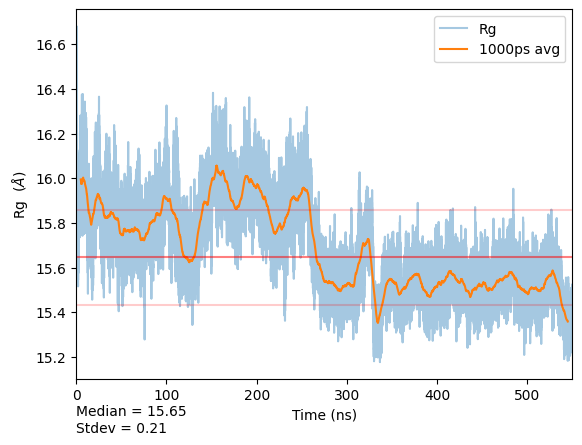

In [ ]:
if radius_of_gyration:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(radius[0]/1000, radius[1], label='Rg', alpha = 0.4)
    # Add axis labels
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Rg  ($\AA$)')

    # Set axis limits
    ax.set_xlim(0, len(radius.T)/100 )

    # plt median and + 1 stdev
    plt_smooth(ax,radius[1], radius[0],1000)
    plt_median(ax, radius[1], label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

### RMSD
Measure RMS deviation from the original structure during the simulation time


In [ ]:
if calculate_RMSD:
    grouplist =[]
    for group in RMSD_groups:
        grouplist.append(f"protein and name CA and resid {group}")

    # Calculate RMSD using the MDAnalysis functionality
    ref_structure = reference_structure

    # Input: simulation trajectory, reference structure, atoms to superimpose, atoms to calculate the RMSD for
    RMSD = rms.RMSD(atomistic_system,      # Trajectory
                    ref_structure,         # Reference structure
                    select="protein and name CA",   #residus selection for superimposition     
                    groupselections = grouplist)  # RMSD groups
    # Run RMSD analysis
    RMSD.run(verbose=True)

In [ ]:
if calculate_RMSD:
    #Option to start the plot at specific time (cut of first ms of equilibration)
    plot_0 = 0

    # Extract data for plotting
    rmsd = RMSD.results.rmsd.T  #T = transpose
    # Extract the time data from the RMSD output. Divide by 1000 to get time in ns
    time = rmsd[1]/1000
    
    # Generate plot for each set of RMSD
    n = 2
    fig, axs = plt.subplots(len(RMSD_groups)+1)
    
    for ax in axs:
        ax.plot(time, rmsd[n],  label="RMSD backbone", alpha=0.4)

        if len(rmsd[1]) > 10000:
            plt_smooth(ax,rmsd[n],rmsd[1],1000)
        else:
            plt_smooth(ax,rmsd[n],rmsd[1],20)

        #smoothed and median + stddev view
        plt_median(ax,rmsd[n],label=True)

        # Add axis labels
        ax.set_ylabel("RMSD  ($\AA$)")

        ax.set_title(RMSD_groups_name[n-2])

        # Set axis limits
        ax.set_xlim(plot_0,len(rmsd[n])/100)
        ax.set_ylim(min(rmsd[n][plot_0+2:]),round(max(rmsd[n]),1)+0.1)
        n = n + 1 

    axs[-1].set_xlabel("Time (ns)")
    # Add legend
    plt.legend()
    fig.set(figheight=14)
    # Show the plot
    plt.show()

### Pairwise RMSD

In [ ]:
if pairwise_RMSD:
    aligner = align.AlignTraj(atomistic_system, atomistic_system, select='name CA',in_memory=False,filename="tmp.xtc")
    aligner.run(verbose=True)

    aligned_atomistic_system = mda.Universe(sim_path + coordinate_file_name,"tmp.xtc")
    matrix = diffusionmap.DistanceMatrix(aligned_atomistic_system, select='name CA')
    matrix.run(verbose=True)
    print(matrix.results.dist_matrix.shape)

In [ ]:
if pairwise_RMSD:
    plt.imshow(matrix.dist_matrix, cmap='viridis')
    plt.xlabel('Frame')
    plt.ylabel('Frame')
    plt.colorbar(label=r'RMSD ($\AA$)')



### RMSF
Calculate RMS fluctuation per residues from an <b>average structure</b>.

In [ ]:
# Generate an average structure
if calculate_RMSF:
    
    if not is_aligned:
        do_trajectory_CAalignement()
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
     
#Run RMSF analysis
    C_alphas = atomistic_system.select_atoms('protein and name CA')
    print("Run RMSF calculation")
    RMSF = rms.RMSF(C_alphas)
    RMSF.run(verbose=True)

Run RMSF calculation


  0%|          | 0/55001 [00:00<?, ?it/s]

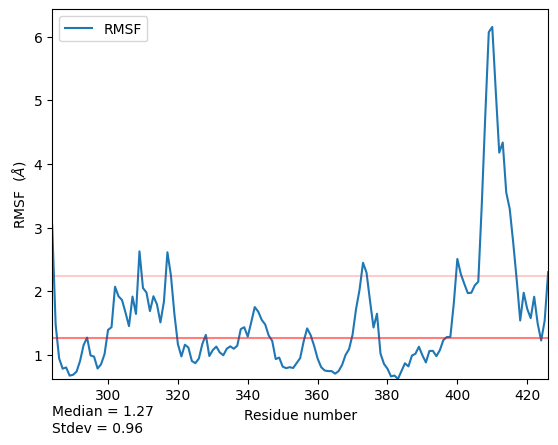

In [ ]:
if RMSF:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(C_alphas.resids, RMSF.results.rmsf, label='RMSF')
    # Add axis labels
    ax.set_xlabel('Residue number')
    ax.set_ylabel('RMSF  ($\AA$)')

    # Set axis limits
    ax.set_xlim(C_alphas.resids[0], C_alphas.resids[-1] )
    ax.set_ylim(min(RMSF.results.rmsf))

    # plt median and + 1 stdev
    plt_median(ax, RMSF.results.rmsf, negative=False, label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

In [ ]:
if RMSF:
    # dynamically add new attributes
    # ('tempfactors' is pre-defined and filled with zeros as default values)
    atomistic_system.add_TopologyAttr('tempfactors')
    C_alphas.tempfactors = RMSF.results.rmsf


#write PDB file with RMS as B factore
    if ligand_name:
        write_group = atomistic_system.select_atoms(f"(protein and name CA) or resname {ligand_name}")
    else:
        write_group = C_alphas

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        write_group.write(sim_path + sim_name +  "_RMSF.pdb")


## H-Bonds

In [ ]:
hbonds = False
if H_bonds and ligand_name:
    from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
    hbonds = HBA(universe=atomistic_system, between=["protein", f"resname {ligand_name}"])

# Guess H and accepetors
    protein_H = hbonds.guess_hydrogens("protein")
    protein_acc = hbonds.guess_acceptors("protein")
    ligand_H = hbonds.guess_hydrogens(f"resname  {ligand_name}")
    ligand_acc =  hbonds.guess_acceptors(f"resname {ligand_name}")

    hbonds.hydrogens_sel = f"({protein_H}) or ({ligand_H})"
    hbonds.acceptors_sel = f"({protein_acc}) or ({ligand_acc})"

    hbonds.run(verbose=True, start=start_frame, stop=stop_frame)

In [ ]:
if hbonds:
    print(hbonds.results.hbonds.shape)

    plt.plot(hbonds.times, hbonds.count_by_time(), lw=2)

    plt.title("Number of hydrogon bonds over time", weight="bold")
    plt.xlabel("Time (ps)")
    plt.ylabel(r"$N_{HB}$")

    plt.show()

In [ ]:
if hbonds:
    for donor, acceptor, count in hbonds.count_by_type():

        donor_resname, donor_type = donor.split(":")
        n_donors = atomistic_system.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms

        # average number of hbonds per donor molecule per frame
        mean_count = 2 * int(count) / (hbonds.n_frames * n_donors)  # multiply by two as each hydrogen bond involves two water molecules
        print(f"{donor} to {acceptor}: {mean_count:.2f}")